In [8]:
import time
import pandas as pd
from pandas import scatter_matrix
import numpy as np
import sklearn
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA, FastICA

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE, ADASYN

from random import randint

%matplotlib inline

### Original data

In [9]:
data_iono = pd.read_csv("/home/wanda/master_project/Data/spain_balance_data.csv",index_col=0)
print data_iono.shape

(446, 41)


In [10]:
data_iono.columns

Index([u'A_index', u'C_flare', u'K_index', u'N_PAIRS', u'N_STATIONS',
       u'kurtosis_delay', u'kurtosis_grad', u'max_elevation', u'max_grad',
       u'max_phase_delay', u'mean_code_delay', u'mean_elevation', u'mean_grad',
       u'mean_phase_delay', u'min_elevation', u'min_grad', u'min_phase_delay',
       u'mse', u'new_regions', u'radio_flux', u'std_grad', u'std_phase',
       u'sunsplot_number', u'sunspot_area', u'bucket_grad',
       u'bucket_grad_mean', u'k_index_bucket', u'elev_min_bucket',
       u'elev_mean_bucket', u'elev_max_bucket', u'grad_elev', u'BIN_LABEL',
       u'LABEL', u'prn', u'network', u'STATIONS', u'PAIRS', u'ID', u'YEAR',
       u'DAY', u'TIME'],
      dtype='object')

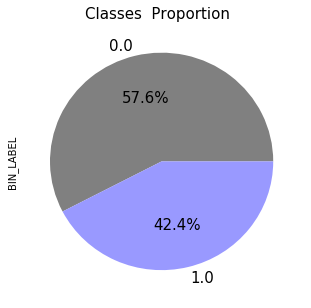

In [11]:
purp = "#b366ff"
blue = "#9999ff"
cool_grey = "#a3a3c2"
other_gray = "#808080"
plt.figure(figsize=(5,5))
plt.figtext(.5,.9,"Classes  Proportion", fontsize=15, ha='center')
data_iono.BIN_LABEL.value_counts().plot(kind='pie',autopct='%1.1f%%', fontsize=15, colors=[other_gray,blue]) 

In our study data is splitted in four parts. 3  Folds or 75% of the data are used to train the algorithms, and will be oversampled since data of class "1" or "True ionospheric event" is less common. The other part is conserved original to test.

In [12]:
print "Each fold has ",data_iono.shape[0]/4.," elements."
print "Elements of class 1 or True Event: ",data_iono[data_iono.BIN_LABEL==1].shape[0]/4.
print "Elements of class 0 or False Event: ",data_iono[data_iono.BIN_LABEL==0].shape[0]/4.

Each fold has  111.5  elements.
Elements of class 1 or True Event:  47.25
Elements of class 0 or False Event:  64.25


In [13]:
train_size = 0.75
cv_size =train_size*0.25
print "Train set has aprox ",data_iono.shape[0]*train_size," elements."
print "Elements of class 1 or True Event: ",data_iono[data_iono.BIN_LABEL==1].shape[0]*cv_size
print "Elements of class 0 or False Event: ",data_iono[data_iono.BIN_LABEL==0].shape[0]*cv_size

Train set has aprox  334.5  elements.
Elements of class 1 or True Event:  35.4375
Elements of class 0 or False Event:  48.1875


In [14]:
data_spain = data_iono[data_iono.network=='rap']
data_iono = data_iono[data_iono.network!='rap']

metadata = ['prn','network','STATIONS','PAIRS', 'ID','YEAR', 'DAY','TIME' ]
labels = ['BIN_LABEL' 'LABEL']
columns = ['A_index', 'C_flare', 'K_index', 'N_PAIRS', 'N_STATIONS',
       'kurtosis_delay', 'kurtosis_grad', 'max_elevation', 'max_grad',
       'max_phase_delay', 'mean_code_delay', 'mean_elevation', 'mean_grad',
       'mean_phase_delay', 'min_elevation', 'min_grad', 'min_phase_delay',
       'mse', 'new_regions', 'radio_flux', 'std_grad', 'std_phase',
       'sunsplot_number', 'sunspot_area', 'bucket_grad',
       'bucket_grad_mean', 'k_index_bucket', 'elev_min_bucket',
       'elev_mean_bucket', 'elev_max_bucket', 'grad_elev']

X = data_iono[columns]
X_spain = data_spain[columns]

print "Dataset shape: ",X.shape
print "Dataset (Spain) shape: ",X_spain.shape
y_bin, y_classes = data_iono.BIN_LABEL, data_iono.LABEL
y_spain = data_spain.BIN_LABEL

Dataset shape:  (430, 31)
Dataset (Spain) shape:  (16, 31)



## Train with 75% --> Use oversampling techiques (Smote and Adasyn)  and cross-validation

## Test 25% --> original data

# Binary Classification: True or False Ionospheric Event


- FP --> Non Ionospheric Event, Labeled as event
- FN --> True Ionospheric Event, Labeled as not events
- TP --> True Ionospheric Event, Labeled as events
- TN --> Non Ionospheric Event, Labeled as not events

# <a href = "https://en.wikipedia.org/wiki/F1_score">Metrics</a>


What is more valuable?

<a href="https://stats.stackexchange.com/questions/61829/relation-between-true-positive-false-positive-false-negative-and-true-negative">**TPR**, FNR, ACC, PRES, F2, F1.   High,  **FNR**, FP low.</a>

*The most important metrics for our case are: TPR, FNR, F2, ACC*

#### TPR

True Positive Rate or Sensitivity or Recall

$${\displaystyle {\mathit {TPR}}={\mathit {TP}}/P={\mathit {TP}}/({\mathit {TP}}+{\mathit {FN}})}$$

#### FNR
False Negative Rate 

$$FNR = \frac{FN}{TP+FN}$$


####  TNR

True Negative Rate  or Specificity (SPC)


$${\displaystyle {\mathit {SPC}}={\mathit {TN}}/N={\mathit {TN}}/({\mathit {TN}}+{\mathit {FP}})} {\mathit {SPC}}={\mathit {TN}}/N={\mathit {TN}}/({\mathit {TN}}+{\mathit {FP}})$$

#### ACC

Accuracy

$${\displaystyle \mathrm {ACC} ={\frac {\mathrm {TP} +\mathrm {TN} }{P+N}}={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {TP} +\mathrm {FP}+\mathrm {TN}  +\mathrm {FN} }}}$$


#### F1 

Is the harmonic mean of precision and sensitivity(TPR)
$${\displaystyle {\mathit {F1}}=2{\mathit {TP}}/(2{\mathit {TP}}+{\mathit {FP}}+{\mathit {FN}})}$$


#### F2 , $F_\beta$ 

Weighs recall higher than precision (by placing more emphasis on false negatives). -->sklearn.metrics.fbeta_score

$$F_\beta= \frac{(1+\beta^2).TP}{(1+\beta^2).TP+\beta^2-FN+FP}$$


#### FOR
False omission Rate

$$FOR = 1 - NPV = \frac{FN}{TN+FN}$$

* -------------------------------------------------------
# Other metrics

#### FPR

False Positive Rate 

$${\displaystyle {\frac {FP}{N}}={\frac {FP}{FP+TN}}} {\displaystyle {\frac {FP}{N}}={\frac {FP}{FP+TN}}}$$


In scikit learn with cv fuction : scoring : string, callable or None, optional, default: None
    A string (see model evaluation documentation) or
    a scorer callable object / function with signature
    ``scorer(estimator, X, y)``


#### PRE 

The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

$${\displaystyle {\text{Precision}}={\frac {TP}{TP+FP}}\,}$$




In [15]:
f2_scorer = make_scorer(fbeta_score, beta=2)

#http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

def fnr_score(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    tp = cm[1][1]*1.
    fn = cm[1][0]*1.
    tn = cm[0][0]*1.
    fp = cm[0][1]*1.
    fnr = fn/(tp+fn)
    return fnr

def fpr_score(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    tp = cm[1][1]*1.
    fn = cm[1][0]*1.
    tn = cm[0][0]*1.
    fp = cm[0][1]*1.
    fpr = fp/(tn+fp)
    return fpr

def for_score(y, y_pred):
    #false omission rate
    cm = confusion_matrix(y, y_pred)
    tp = cm[1][1]*1.
    fn = cm[1][0]*1.
    tn = cm[0][0]*1.
    fp = cm[0][1]*1.
    fpr = fn/(tn+fn)
    return fpr

fnr_scorer = make_scorer(fnr_score)
fpr_scorer = make_scorer(fpr_score)
for_scorer = make_scorer(for_score)

In [16]:
def learning_curve_scores(clf,X_train,y_train, X_test,y_test, score,train_sizes = np.linspace(.1, 1.0, 5),beta=None):
    #Scores for a model when experience increases.
    lc_score_train, lc_score_test = [], []
    for size in train_sizes:
        # Get random section from train data, stratified.
        if size!=1.0:
            X_t,__, y_t, __ = train_test_split(X_train, y_train, train_size=size, random_state=randint(1,100), stratify= y_train)
        else:
            X_t, y_t = X_train, y_train  
            
        # Fit with train
        clf.fit(X_t,y_t)
        # Predict on Train
        y_pred_train = clf.predict(X_t)
        # Predict on Test
        y_pred_test = clf.predict(X_test)
        # Save scores
        if beta!= None:
            lc_score_train.append(score(y_t, y_pred_train,beta))
            lc_score_test.append(score(y_test, y_pred_test,beta))     
        else:
            lc_score_train.append(score(y_t, y_pred_train))
            lc_score_test.append(score(y_test, y_pred_test))     
    
    return lc_score_train, lc_score_test

In [17]:
def plot_lc(title, scores,mask):
    metrics = ['F2','PRE','TPR']
    for metric in metrics:
        plt.figure()
        plt.title(title+" "+metric)
        #if ylim is not None:
            #plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        train_sizes = np.linspace(.1, 1.0, 5)
        train_scores_mean = np.mean(np.array(scores[metric+'_train'])[mask],axis=0)
        train_scores_std =np.std(np.array(scores[metric+'_train'])[mask],axis=0)
        test_scores_mean = np.mean(np.array(scores[metric+'_test'])[mask],axis=0)
        test_scores_std = np.std(np.array(scores[metric+'_test'])[mask],axis=0)
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Test score")#label="Cross-validation score"

        plt.legend(loc="best")
    return plt

*-----------------------------------------------------------------------------------*
# Classifier: Logistic Regression (logit or maximum entropy)

- **Newton Solver: ** L2 Penalty More quicker. Multiclass can be multinomial or one vs all ('ovr'). The first is always better clasifier.

- **Lbfgs Solver: **quasi newton. L2 Penalty More quicker. Multiclass can be multinomial or one vs all ('ovr'). The first is always better clasifier.

- **Stochastic Average Gradient descent (sag) solver: **L2 Penalty More quicker with a big number of features and elements. Multiclass can be multinomial or one vs all ('ovr'). The first is always better clasifier.

- **Coordinate system (liblinear) solver: **L1 Penalty .One vs the rest. Not multinomial.

### Model selection with train data

- Split data with stratified split (75% Train, 25% Test)
- Cross validation on train (oversampling option) using many metrics, using an algorithm with different hyperparameters to find the best model. 
- Repeat to prove stability.

In [18]:
def model_selection(X,y,iters,folds_cv, clf,params,n_proc,use_oversampling=True):
    best = [] #list of index (id) of best estimator on each iteration
    scores_test = [] # performance on unseen data for the best estimator. Trainig 75% and then testin 25%
    #Diccionary with learning curve scores for the best estimator for each iteration on train and test
    lc_scores = {'PRE_train':[],'PRE_test':[], 'ACC_train':[],'ACC_test':[],
                 'TPR_train':[],'TPR_test':[],'FPR_train':[],'FPR_test':[],
                 'FOR_train':[], 'FOR_test':[],'FNR_train':[],'FNR_test':[],
                 'F2_train': [],'F2_test': []
                 }
    ada = ADASYN()
    #fbeta_score(y_test, y_pred, beta=2) 
    for i in range(iters):
        #print "i = ", i
        #Split data with statified 25% Test, 75% Train
        #this preservs the % of samples for each class.
        X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.25, test_size=0.25, random_state=randint(1,100), stratify= y)

        #Oversample using ADASYN algorithm
        if use_oversampling==True:
            X_train, y_train = ada.fit_sample(X_train, y_train)

        #Cross validation object with stratified  folds.
        cv = StratifiedKFold(n_splits = folds_cv, random_state = randint(1,100), shuffle=True)

        #Select best model Tuning hyperparameters using GridSearch on parameters space
        ##refit score is the metric that chooses the model
        
        scoring = {'FNR': fnr_scorer,'FPR':fpr_scorer,'F2':f2_scorer,
                  'TPR':'recall', 'ACC':'accuracy', 'PRES':'precision',
                  'FOR': for_scorer} 
        
        grid = GridSearchCV(estimator=clf, param_grid = params,
                            scoring=scoring, n_jobs=n_proc, refit='F2', 
                            cv=cv,verbose=0)

        grid.fit(X_train, y_train) 

        #Best model on training data
        #results = grid.cv_results_
        best.append(grid.best_index_ )

        #Save performance on unseen (test) data (25%)
        y_pred = grid.predict(X_test) #run estimator with the best found parameters
        score_test = {'PRE':precision_score(y_test, y_pred), 'ACC':accuracy_score(y_test, y_pred),
                     'TPR':recall_score(y_test, y_pred), 'FPR':fpr_score(y_test, y_pred),
                     'FOR':for_score(y_test, y_pred), 'FNR':fnr_score(y_test, y_pred),
                      'F2': fbeta_score(y_test, y_pred, beta=2), 'PREDICTOR_INDEX':grid.best_index_}
        scores_test.append(score_test)

        #Save learning curve information Train/Test for the best estimator in this iteration.
        ## This scores are generated increasing the training size, the test size is always the same.
        ## Cross validationis not used in  this step 
        pre_scores_iter_0, pre_scores_iter_1 = learning_curve_scores(clf=grid.best_estimator_,X_train=X_train,y_train=y_train, X_test=X_test,y_test=y_test, score = precision_score)
        acc_scores_iter_0, acc_scores_iter_1 = learning_curve_scores(clf=grid.best_estimator_,X_train=X_train,y_train=y_train, X_test=X_test,y_test=y_test, score = accuracy_score)
        tpr_scores_iter_0, tpr_scores_iter_1 = learning_curve_scores(clf=grid.best_estimator_,X_train=X_train,y_train=y_train, X_test=X_test,y_test=y_test, score = recall_score)
        fpr_scores_iter_0, fpr_scores_iter_1 = learning_curve_scores(clf=grid.best_estimator_,X_train=X_train,y_train=y_train, X_test=X_test,y_test=y_test, score = fpr_score)
        for_scores_iter_0, for_scores_iter_1 = learning_curve_scores(clf=grid.best_estimator_,X_train=X_train,y_train=y_train, X_test=X_test,y_test=y_test, score = for_score)
        fnr_scores_iter_0, fnr_scores_iter_1 = learning_curve_scores(clf=grid.best_estimator_,X_train=X_train,y_train=y_train, X_test=X_test,y_test=y_test, score = fnr_score)
        f2_scores_iter_0, f2_scores_iter_1 = learning_curve_scores(clf=grid.best_estimator_,X_train=X_train,y_train=y_train, X_test=X_test,y_test=y_test, score = fbeta_score,beta=2)
        
        
        lc_scores['PRE_train'].append(pre_scores_iter_0)
        lc_scores['PRE_test'].append(pre_scores_iter_1)
        lc_scores['ACC_train'].append(acc_scores_iter_0)
        lc_scores['ACC_test'].append(acc_scores_iter_1)
        lc_scores['TPR_train'].append(tpr_scores_iter_0)
        lc_scores['TPR_test'].append(tpr_scores_iter_1)
        lc_scores['FPR_train'].append(fpr_scores_iter_0)
        lc_scores['FPR_test'].append(fpr_scores_iter_1)
        lc_scores['FOR_train'].append(for_scores_iter_0)
        lc_scores['FOR_test'].append(for_scores_iter_1)
        lc_scores['FNR_train'].append(fnr_scores_iter_0)
        lc_scores['FNR_test'].append(fnr_scores_iter_1)
        lc_scores['F2_train'].append(f2_scores_iter_0)
        lc_scores['F2_test'].append(f2_scores_iter_1)
    
    results = grid.cv_results_
    return best, scores_test,  lc_scores, results


In [19]:
nproc = 1
params = {'C':np.arange(0.1,1,0.1),
          'solver':['newton-cg','lbfgs','sag', 'liblinear']}
best, scores_test,  lc_scores, results = model_selection(X=X,y=y_bin,iters=100,folds_cv = 3, clf = LogisticRegression(),params = params,n_proc=nproc,use_oversampling=False)
best_o, scores_test_o,  lc_scores_o, results_o = model_selection(X=X,y=y_bin,iters=100,folds_cv = 3, clf = LogisticRegression(),params = params,n_proc=nproc,use_oversampling=True)

/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


## Select model with best performance and plot learning curve

Axes(0.125,0.125;0.775x0.755)
1     14
13     9
3      8
9      8
0      6
29     6
5      6
33     6
25     4
19     4
15     4
4      3
7      3
21     3
11     2
16     2
17     2
27     2
12     1
23     1
24     1
28     1
31     1
2      1
32     1
35     1
Name: Best, dtype: int64


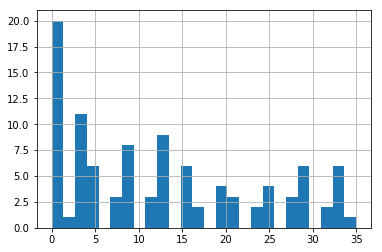

In [20]:
df_best = pd.DataFrame(best, columns= ['Best'])
print df_best.Best.hist(bins=len(df_best.Best.unique()) )
print df_best.Best.value_counts()

Axes(0.125,0.125;0.775x0.755)
0     13
1      9
2      9
5      7
3      6
7      6
4      5
9      4
20     4
13     4
29     3
6      3
33     3
15     3
32     2
28     2
21     2
17     2
8      2
35     1
11     1
12     1
19     1
23     1
24     1
25     1
27     1
30     1
31     1
16     1
Name: Best, dtype: int64


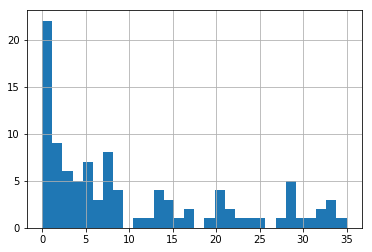

In [21]:
df_best_o = pd.DataFrame(best_o, columns= ['Best'])
print df_best_o.Best.hist(bins=len(df_best_o.Best.unique()) )
print df_best_o.Best.value_counts()

In [22]:
best_model = 1
best_model_o = 0
#dfresults_exam.loc[best_model,:] #best
#para todos no solo el mejor

In [23]:
dfr = pd.DataFrame(results)
dfr.loc[best_model,['param_solver','param_C']]

param_solver    lbfgs
param_C           0.1
Name: 1, dtype: object

In [24]:
dfr_o = pd.DataFrame(results_o)
dfr_o.loc[best_model_o,['param_solver','param_C']]

param_solver    newton-cg
param_C               0.1
Name: 0, dtype: object

In [25]:
mask_best = np.array(df_best[df_best.Best==best_model].index)
print mask_best.shape
mask_best_o = np.array(df_best[df_best_o.Best==best_model_o].index)
print mask_best_o.shape

(14,)
(13,)


## Learning curves on train data for selected model

<module 'matplotlib.pyplot' from '/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

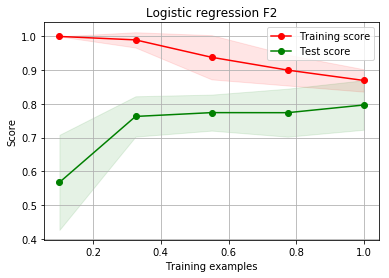

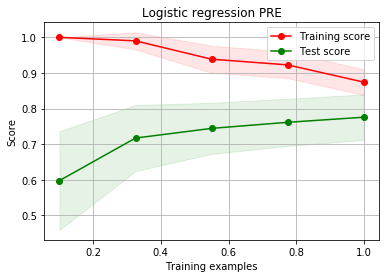

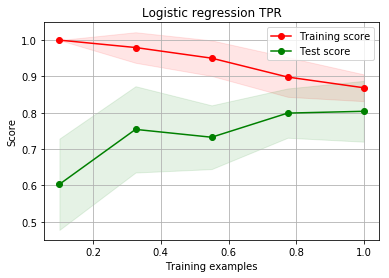

In [26]:
plot_lc(title= "Logistic regression", scores = lc_scores,mask = mask_best)

<module 'matplotlib.pyplot' from '/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

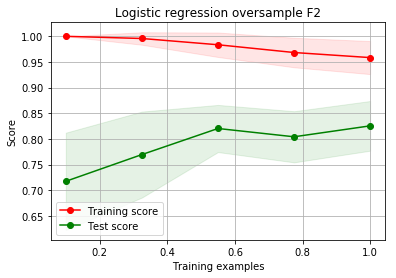

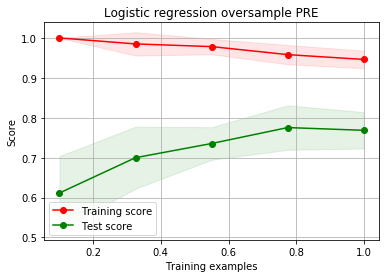

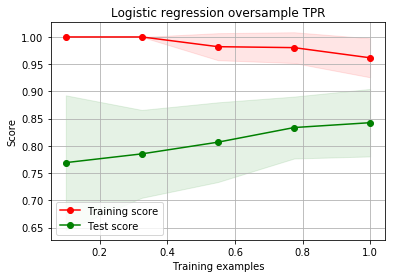

In [28]:
 plot_lc(title= "Logistic regression oversample", scores = lc_scores_o,mask = mask_best_o)

# Test Model Performance

In [29]:
test_scores = pd.DataFrame(scores_test)
test_scores_best = test_scores[test_scores.PREDICTOR_INDEX==best_model]
test_scores_best.describe()
#ojo for alta 

,ACC,F2,FNR,FOR,FPR,PRE,PREDICTOR_INDEX,TPR
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.000000
mean,0.828042,0.796763,0.196013,0.131057,0.156044,0.775520,1.0,0.803987
std,0.050548,0.076152,0.086879,0.050914,0.054928,0.066528,0.0,0.086879
min,0.777778,0.669856,0.093023,0.059701,0.030769,0.696429,1.0,0.651163
25%,0.789352,0.760369,0.110465,0.085470,0.138462,0.733333,1.0,0.767442
50%,0.810185,0.779882,0.209302,0.145313,0.138462,0.764742,1.0,0.790698
75%,0.851852,0.848821,0.232558,0.158730,0.184615,0.800000,1.0,0.889535
max,0.944444,0.915493,0.348837,0.211268,0.261538,0.951220,1.0,0.906977


In [30]:
test_scores_o = pd.DataFrame(scores_test_o)
test_scores_best_o = test_scores[test_scores_o.PREDICTOR_INDEX==best_model]
test_scores_best_o.describe()

,ACC,F2,FNR,FOR,FPR,PRE,PREDICTOR_INDEX,TPR
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.849794,0.812939,0.186047,0.123097,0.126496,0.811482,8.666667,0.813953
std,0.047163,0.060695,0.063689,0.039326,0.047901,0.065834,8.689074,0.063689
min,0.796296,0.727700,0.093023,0.059701,0.030769,0.723404,1.000000,0.720930
25%,0.824074,0.776256,0.162791,0.109375,0.107692,0.760870,3.000000,0.790698
50%,0.851852,0.817757,0.186047,0.121212,0.123077,0.815789,5.000000,0.813953
75%,0.861111,0.833333,0.209302,0.147541,0.153846,0.833333,9.000000,0.837209
max,0.944444,0.915493,0.279070,0.179104,0.200000,0.951220,27.000000,0.906977


In [31]:
folder_results = 'Results_Spain/'
str_clf = 'LR'

test_scores.to_csv(folder_results+str_clf+"_test.csv")
test_scores_o.to_csv(folder_results+str_clf+"_o_test.csv")

In [32]:
cols = pd.DataFrame(results).columns
params_df = [ i for i in cols if 'param' in i]
pd.DataFrame(results)[params_df].to_csv(folder_results+str_clf+'_algorithms_params.csv')
pd.DataFrame(results)[params_df].head()

,param_C,param_solver,params
0,0.1,newton-cg,"{u'C': 0.1, u'solver': u'newton-cg'}"
1,0.1,lbfgs,"{u'C': 0.1, u'solver': u'lbfgs'}"
2,0.1,sag,"{u'C': 0.1, u'solver': u'sag'}"
3,0.1,liblinear,"{u'C': 0.1, u'solver': u'liblinear'}"
4,0.2,newton-cg,"{u'C': 0.2, u'solver': u'newton-cg'}"


In [33]:
cols_o = pd.DataFrame(results_o).columns
params_df_o = [ i for i in cols_o if 'param' in i]
pd.DataFrame(results_o)[params_df_o].to_csv(folder_results+str_clf+'_algorithms_params_o.csv')
pd.DataFrame(results_o)[params_df_o].head()

,param_C,param_solver,params
0,0.1,newton-cg,"{u'C': 0.1, u'solver': u'newton-cg'}"
1,0.1,lbfgs,"{u'C': 0.1, u'solver': u'lbfgs'}"
2,0.1,sag,"{u'C': 0.1, u'solver': u'sag'}"
3,0.1,liblinear,"{u'C': 0.1, u'solver': u'liblinear'}"
4,0.2,newton-cg,"{u'C': 0.2, u'solver': u'newton-cg'}"


# Dataset info 

**Metadata** 

- Day
- Year
- event ID

----------------------
### Predictor variables

- number of stations  **Cuantitativo**
- number of pairs  **Cuantitativo**
- mean elevation **Cuantitativo**
- lowest elevation **Cuantitativo**
- biggest elevation **Cuantitativo**

** Double frequency phase_delay signal information **

- Phase Delay mean **for each station** **Cuantitativo**
- Phase Delay standar deviation **Cuantitativo**
- Phase Delay max **Cuantitativo**
- Phase Delay min **Cuantitativo**
- Phase Delay std **Cuantitativo**
- Phase Delay kurtosis **Cuantitativo**
- Code Delay mean **Cuantitativo**
- Mean squared error between code and phase **Cuantitativo**


**Gradient signal information**


- Kurtosis mean **Cuantitativo**
- Gradient mean **Cuantitativo**
- Gradient max **Cuantitativo**
- Gradient min **Cuantitativo**
- **Outliers detected** 
-  **Segments descriptor ? **


**Space weather data**


- Kp index (Every 3 hours) **Cuantitativo**
- A index (Daily) **Cuantitativo**
- Sunspot number **Cuantitativo**
- Sunspot area **Cuantitativo**
- Radio Flux Penticton 10.7 cm   **Cuantitativo**
-  X-Ray flux flares c y s **Cuantitativo**
-------------------------------

### Original Classes
**True**
- Gradients with few peaks (conus). **(1)**
- Gradients for scintillation (regme) are very varying. **(2)**

**False**
- Short arcs that create high variations on the substraction.**(3)**
- Outliers in one station (faulty for some reason) creating false gradient with all the neighbours.**(4)**
- Outliers in all stations at some time.**(5)**

There's very few elements on classes 4, 5 so we can add them to class 3.

In [ ]:
#https://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat